In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import ipympl
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual,HBox, Layout,VBox
import openbabel as ob
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import nglview as nv
from nglview.viewer_control import ViewerControl
import mplcursors

In [2]:
from load_data import load_file
from helper_functions import calc_scaling,single_rotD,single_rotP,rotate_molecule
from calc_average import full_average,full_average_IR,full_average_R,full_average_R_orth,numerical_sector_average
from calc_single import oriented_IR,oriented_R,single_rot_IR,single_rot_R
from plotting_functions import create_average_spec_single

In [6]:
outfilename="freq-19813-90-2.out"   # less accurate
filename="freq-19813-90-2.fchk"   # more accurate
molcode=(filename.split(".")[0]).split("-",1)[1]
print("Molecule ",molcode)

fr,Z,Q,D,P,nat,aniso=load_file(filename)

obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("out", "can") 
obConversion.SetOptions(str("h"), ob.OBConversion.OUTOPTIONS)
mol0 = ob.OBMol()
obConversion.ReadFile(mol0, outfilename)

outMDL = obConversion.WriteString(mol0)
spl=outMDL.split("\t")
smiles = spl[0]
if len(smiles)<2:
        print("error in smiles generation")
        smiles=filename
print("SMILES: ",smiles)

mol=Chem.MolFromSmiles(smiles)
#display(mol)

#obConversion.SetOutFormat("mol") 
#sdfmol = obConversion.WriteString(mol0)


Molecule  19813-90-2
SMILES:  [Au]Sc1[cH][cH]c([cH][cH]1)c1[cH][cH][cH][cH][cH]1


Most similar SAM molecule:  Sc1ccc(cc1)c1ccccc1
Similarity: 0.85


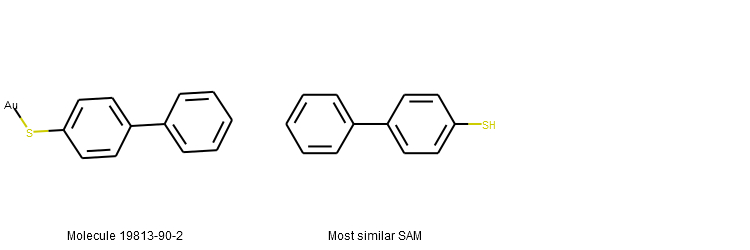

In [7]:
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs
from rdkit.Chem import AllChem

# Similarity to known self-assembly materials 
def read_smiles_data(fname):
    SAMsmiles=[]
    with open(fname) as inpfile:
        line = inpfile.readline()
        while line:
            SAMsmiles.append(line.split()[1])
            line = inpfile.readline()
    return SAMsmiles

SAMsmiles=read_smiles_data("smiles_SAM_materials.txt")
ms=[]
rad=1
for s in SAMsmiles:
    if Chem.MolFromSmiles(s)==None:
        ms.append(None)
        continue
    m=Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(s)))
    ms.append(m) 
fps=[]
for x in ms:
    if x==None:
        fps.append(None)
        continue
    fps.append(AllChem.GetMorganFingerprint(x, radius=rad, useCounts=1,useFeatures=0))
    
molfp = AllChem.GetMorganFingerprint(mol, radius=rad, useCounts=1,useFeatures=0)
sim=np.zeros((len(fps)))
for j, fps2 in enumerate(fps):
        if fps2==None:
            sim[j]=0
            continue
        sim[j]=DataStructs.DiceSimilarity(molfp,fps2)

mmol=np.argsort(sim)[-1] 
print("Most similar SAM molecule: ",SAMsmiles[mmol])
print("Similarity: {:.2f}".format(DataStructs.DiceSimilarity(molfp,fps[mmol])))
# display(ms[mmol])
# fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint( 
#                     ms[mmol], mol,lambda mo,
#                     idx: SimilarityMaps.GetMorganFingerprint(mo, atomId=idx, radius=rad, 
#                                                              useFeatures=0,fpType='count'), 
#                     metric=DataStructs.DiceSimilarity)
Chem.Draw.MolsToGridImage((mol,ms[mmol]), subImgSize=(250,250),
                          legends=('Molecule {}'.format(molcode),'Most similar SAM'))

In [6]:
def plot_spectrum_oriented(laser,T,freqrange,sclf,broadening,gammaIR,gammaR,phi,theta,show_av):
    # modes: list of normal modes to calculate
    modes=range(0,len(fr)) 

    single=1    # get intensities for single rotations

    torad=math.pi/180
    th=theta*torad  
    ph=phi*torad 

    Lm=1
    
    Drot,Prot,rotfile,cell=rotate_molecule(mol0,outfilename,D,P,phi=ph,theta=th)
    
    # display molecule in 3D
    view = nv.NGLWidget()
    comp = view.add_component(rotfile)
    control = ViewerControl(view=view)
    control.spin([1,0,0],-90*torad)
    control.spin([0,0,1],40*torad)
    view.shape.add_arrow([0,0,0], [8,0,0], [ 0, 0, 1 ], 0.2, 'x')
    view.shape.add_arrow([0,0,0], [0,8,0], [ 1, 0, 0 ], 0.2, 'y')
    view.shape.add_arrow([0,0,0], [0,0,8], [ 0, 0.8, 0.2 ], 0.2, 'z')
    view.shape.add('text', [7, 0, 0.5], [ 0, 0, 1 ], 3, 'x')
    view.shape.add('text', [0, 7, 0.5], [ 1, 0, 0 ], 3, 'y')
    view.shape.add('text', [0, 0.5, 7], [ 0, 0.8, 0.2 ], 3, 'z')
    display(view)

    print("Molecular cell dimensions: ({:.2f},{:.2f},{:.2f}) ".format(cell[0],cell[1],cell[2])+u'\u212B')
    print("Gap size: {:.2f} ".format(cell[2])+u'\u212B')
    print("Occupied surface area: {:.2f} ".format(cell[0]*cell[1])+u'\u212B\u00B2')
    print("Anisotropy: {:.2f}".format(aniso))
    
    # calculate intensity scaling factors
    v0= math.pow(10, 7)/laser
    scalingIR,scaling,scalingexp,scalingpolar= calc_scaling(T)

    # Full orientation averages
    nummodes=len(modes)
    conv_av=np.zeros((nummodes))  # conversion intensity
    ir_av=np.zeros((nummodes))    # IR intensity
    r_av=np.zeros((nummodes))     # Raman Stokes intensity, parallel fields
#    r_a_av=np.zeros((nummodes))   # Raman anti-Stokes intensity, parallel fields
#    r_av_ort=np.zeros((nummodes)) # Raman Stokes intensity, orthogonal fields

    # Single orientations
    ir_single=np.zeros((nummodes))   # IR intensity
    r_single=np.zeros((nummodes))    # Raman Stokes, parallel fields
    conv_single=np.zeros((nummodes)) # Conversion intensity, parallel fields

    for n,m in enumerate(modes):

    # Calculate frequency-dependent scaling factors
        # Usual Stokes for thermal population
        scalingR=Lm*scaling* math.pow(v0 - fr[m], 4) / (
                    fr[m] * (1 - math.exp(scalingexp * fr[m]))) 
        # Usual anti-Stokes for thermal population
        scalingaR=Lm*scaling* math.pow(v0 + fr[m], 4) / fr[m] *(
               1/(-1+math.exp(-scalingexp * fr[m]))) # 
        # For THOR: anti-Stokes without thermal population
        scalingTHOR=Lm*scaling* math.pow(v0 + fr[m], 4) / fr[m] 

    # Calculate intensities for full orientation average
        if show_av:
            conv_av[n] = scalingIR *scalingTHOR*full_average(Drot[m],Prot[m])  
            ir_av[n]=scalingIR*full_average_IR(Drot[m]) 
            Rav=full_average_R(Prot[m])
            r_av[n]=scalingR*Rav 
         # Not used yet:        
         #   r_a_av[n]=scalingaR*Rav 
         #   r_ort,depol=full_average_R_orth(Prot[m])
         #   r_av_ort[n]=scalingR*r_ort 

    # Calculate intensities for a single orientation
        ir=single_rot_IR(Drot[m],a=ph,b=th,c=0) 
        r=single_rot_R(Prot[m],a=ph,b=th,c=0)
        ir_single[n]=scalingIR*ir
        r_single[n]=scalingR*r
        conv_single[n]=scalingIR*scalingTHOR*ir*r
   
    xmin=freqrange[0]
    xmax=freqrange[1]
    res=0.2                      

    title=r'$\phi$={:.1f}$\degree$ $\theta$={:.1f}$\degree$'.format(ph/torad,th/torad)
    wn,R_spec,IR_spec,conv_spec,freqs,prod_ints,R_ints,IR_ints=create_average_spec_single(fr,ir_single, 
                                                                        r_single,conv_single,xmin,xmax,
                                                                        res,gammaIR,gammaR,sclf)
    wn,R_spec_av,IR_spec_av,conv_spec_av,freqs,prod_ints_av,R_ints_av,IR_ints_av=create_average_spec_single(
                                                                        fr,ir_av,r_av,conv_av,xmin,xmax,
                                                                        res,gammaIR,gammaR,sclf)    
    plt.rcParams.update({'font.size': 16})
    plt.close('Spectrum')
    fig=plt.figure('Spectrum')
    fig.set_size_inches(8, 5)
    ax2=fig.add_subplot(311)
    ax3=fig.add_subplot(312,sharex=ax2)
    ax1=fig.add_subplot(313,sharex=ax2)    
    pmin=0 
    pmax=int((xmax-xmin)/res)
    
    maxpr0=np.max(prod_ints)
    maxI0=np.max(IR_ints)
    maxR0=np.max(R_ints)
    if broadening=='broadened':
        ax3.fill_between(wn,R_spec,alpha=0.6,color='b',label='Raman')
        line1=ax3.plot(wn,R_spec,alpha=0.6,color='b',label='Raman')
        ax2.fill_between(wn,IR_spec,alpha=0.6,color='r',label='IR') 
        line2=ax2.plot(wn,IR_spec,alpha=0.6,color='r',label='IR')
        ax1.fill_between(wn,conv_spec,alpha=0.6,color='purple',label='Conv.') 
        line3=ax1.plot(wn,conv_spec,alpha=0.6,color='purple',label='Conv.')
        maxpr0=np.max(conv_spec[pmin:pmax]) 
        maxI0=np.max(IR_spec[pmin:pmax])
        maxR0=np.max(R_spec[pmin:pmax])
        c1 = mplcursors.cursor(line1)
        c2 = mplcursors.cursor(line2)
        c3 = mplcursors.cursor(line3)

    elif broadening=='broadened+stick':
        ax3.fill_between(wn,(gammaR*math.pi)/2*R_spec,alpha=0.6,color='b',label='Raman')
        ax2.fill_between(wn,(gammaIR*math.pi)/2*IR_spec,alpha=0.6,color='r',label='IR') 
        ax1.fill_between(wn,(gammaIR*math.pi)/2*(gammaR*math.pi)/2*conv_spec,alpha=0.6,color='purple',label='Conv.') 

        markerline, stemline, baseline, =ax2.stem(freqs,IR_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='IR')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)  
        c4 = mplcursors.cursor(markerline)
        markerline, stemline, baseline, =ax3.stem(freqs,R_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Raman')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)  
        c5 = mplcursors.cursor(markerline)
        markerline, stemline, baseline, =ax1.stem(freqs,prod_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Conv.')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)
        c6 = mplcursors.cursor(markerline)
             
    elif broadening=='stick':
        markerline, stemline, baseline, =ax2.stem(freqs,IR_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='IR')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)
        c1 = mplcursors.cursor(markerline)
        markerline, stemline, baseline, =ax3.stem(freqs,R_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Raman')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)  
        c2 = mplcursors.cursor(markerline)
        markerline, stemline, baseline, =ax1.stem(freqs,prod_ints,
                                                 'k',basefmt='k', markerfmt='ok',
                                                  use_line_collection=True,bottom=0,label='Conv.')
        plt.setp(stemline, linewidth = 1.25,alpha=0.6)
        plt.setp(markerline, markersize = 2,alpha=0.6)
        c3 = mplcursors.cursor(markerline)
    maxpr=maxpr0
    maxI=maxI0
    maxR=maxR0
    if show_av:
        maxpr1=np.max(prod_ints_av) 
        maxI1=np.max(IR_ints_av) 
        maxR1=np.max(R_ints_av) 
        if broadening=='broadened':
            ax3.fill_between(wn,R_spec_av,alpha=0.6,color='grey',label='Raman av')
            ax2.fill_between(wn,IR_spec_av,alpha=0.6,color='grey',label='IR av')
            ax1.fill_between(wn,conv_spec_av,alpha=0.6,color='grey',label='Conv. av')
            maxpr1=np.max(conv_spec_av[pmin:pmax]) 
            maxI1=np.max(IR_spec_av[pmin:pmax])
            maxR1=np.max(R_spec_av[pmin:pmax])
           
        elif broadening=='broadened+stick':
            ax3.fill_between(wn,(gammaR*math.pi)/2*R_spec_av,alpha=0.6,color='grey',label='Raman av')
            ax2.fill_between(wn,(gammaIR*math.pi)/2*IR_spec_av,alpha=0.6,color='grey',label='IR av')
            ax1.fill_between(wn,(gammaIR*math.pi)/2*(gammaR*math.pi)/2*conv_spec_av,alpha=0.6,color='grey',label='Conv. av')

            markerline, stemline, baseline, =ax2.stem(freqs,IR_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='IR')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            
            markerline, stemline, baseline, =ax3.stem(freqs,R_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Raman')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            markerline, stemline, baseline, =ax1.stem(freqs,prod_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Conv.')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            
        elif broadening=='stick':
            markerline, stemline, baseline, =ax2.stem(freqs,IR_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='IR')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            markerline, stemline, baseline, =ax3.stem(freqs,R_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Raman')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
            markerline, stemline, baseline, =ax1.stem(freqs,prod_ints_av,
                                                     'grey',basefmt='grey', markerfmt='ok',
                                                      use_line_collection=True,bottom=0,label='Conv.')
            plt.setp(stemline, linewidth = 1.25,alpha=0.6)
            plt.setp(markerline, markersize = 2,alpha=0.6)  
    
        maxpr=max(maxpr0, maxpr1) 
        maxI=max(maxI0,maxI1)
        maxR=max(maxR0,maxR1) 
    plt.xlim(xmin,xmax)
    ax1.set_ylim(-maxpr/100,1.2*maxpr)
    ax2.set_ylim(-maxI/100,1.2*maxI)
    ax3.set_ylim(-maxR/100,1.2*maxR)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0),useMathText=True)
    ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0),useMathText=True)
    ax3.ticklabel_format(axis="y", style="sci", scilimits=(0,0),useMathText=True)
    ax2.set_title(title)
    plt.xlabel('Wavenumber (cm$^{-1}$)')
    ax2.set_ylabel('IR',color='r')
    ax3.set_ylabel('Raman',color='b')
    ax1.set_ylabel('Conv.',color='purple')
    ax1.yaxis.set_label_coords(-0.07,0.5)
    ax2.yaxis.set_label_coords(-0.07,0.5)
    ax3.yaxis.set_label_coords(-0.07,0.5)
    fig.tight_layout(pad=1.8, w_pad=0.01, h_pad=0.01)

    return fig

In [11]:
%matplotlib widget

interactive_plot = interactive(plot_spectrum_oriented, {'manual': True}, 
         laser=widgets.BoundedFloatText(value=785,min=500,max=1100.0,step=0.1,description='Raman laser /nm',
                                        style={'description_width': 'initial'}),
         T=widgets.BoundedFloatText(value=298.15,min=200,max=500.0,step=0.01,description='Temperature /K',
                                    style={'description_width': 'initial'}),
         freqrange=widgets.FloatRangeSlider(min=0,max=3800,value=[30,1000],step=1,
                    orientation='horizontal',description='Frequency range (cm-1):', 
                    layout=widgets.Layout(width='500px', description_width='400px'),
                    style={'description_width': 'initial'}),
         sclf=widgets.FloatSlider(value=0.98,min=0.9,max=1.1,step=0.01,description='Frequency scaling factor',
                                  style={'description_width': 'initial'}),
         broadening=widgets.RadioButtons(options=[('broadened'), ('stick'),('broadened+stick')],
                                         description='Type of spectrum:',style={'description_width': 'initial'}),
         gammaIR=widgets.FloatSlider(value=10, description='FWHM IR', max=50, min=0.1),
         gammaR=widgets.FloatSlider(value=10, description='FWHM R', max=50, min=0.1),
         phi=widgets.BoundedFloatText(value=0,min=0,max=360.0,step=0.1,description=r'$\phi$ (rotate around z)',
                                      style={'description_width': 'initial'}),
         theta=widgets.BoundedFloatText(value=0,min=0,max=90.0,step=0.1,description=r'$\theta$ (rotate around x)',
                                        style={'description_width': 'initial'}),
         show_av=widgets.Checkbox(value=False,description='Show full orientation average'),
         );

output = interactive_plot.children[-1]
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap')) 
output.layout.height = '1000px'
display(VBox([controls,output]))